In [1]:
pipeline_dir = 'C:/Users/ys2605/Desktop/stuff/slow_dynamics_analysis'

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

sys.path.append(pipeline_dir + '/functions')
from f_sd_utils import f_get_fnames_from_dir, f_load_firing_rates, f_get_frames, f_get_stim_trig_resp, f_compute_tuning
from f_sd_utils import f_save_fig


In [2]:
## load datasets and save parameters 
data_dir = 'F:/AC_data/caiman_data_echo/'
# search for files to load using tags in the filename
flist = f_get_fnames_from_dir(data_dir, ext_list = ['mat'], tags=['cont', '_processed_data'])

firing_rates_all = []
trial_types_all = []
stim_times_all = []
isi_all = []
volume_period_all = []

# here you can limit how many datasets to analyze
for n_fl in range(len(flist)):   # len(flist) or some number
    # loading raw firing rates, trial types, and stimuli times
    # here you can indicate to use oasis deconvolution or smoothdfdt
    data_out = f_load_firing_rates(fpath=data_dir + flist[n_fl], deconvolution='oasis', smooth_std_duration=0.1)      # oasis, smoothdfdt; normally smooth with 0.1sec      # oasis, smoothdfdt; normally smooth with 0.1sec 

    # extract firing rates data and parameters we will use from each dataset
    if data_out['files_loaded']:
        firing_rates_all.append(data_out['firing_rates'])
        trial_types_all.append(data_out['trial_types'])
        stim_times_all.append(data_out['stim_times'])
        isi_all.append(data_out['isi'])
        volume_period_all.append(data_out['volume_period'])

In [3]:
## calculate cell tuning and extract responsive cells
# indicate a list of trial types to analyze. In this case the trial types are indexed from 1-10
trials_analyze = np.arange(1,11)

trial_frames, plot_t_tuning = f_get_frames(trial_win = [-1, 2], frame_rate = 1000/np.mean(volume_period_all))

resp_cells_all = []
for n_fl in range(len(firing_rates_all)):  
    # computing stimulus triggered average (neurons, frames, trials)
    stim_trig_resp = f_get_stim_trig_resp(firing_rates_all[n_fl], stim_times_all[n_fl], trial_frames = trial_frames)

    print('computing stats dset %d/%d' % (n_fl+1, len(firing_rates_all)))
    resp_cells = f_compute_tuning(stim_trig_resp, trial_types_all[n_fl], trials_analyze, plot_t_tuning, num_samp=2000, z_thresh = 3, sig_resp_win = [0, 1.2])
    resp_cells_all.append(resp_cells)


computing stats dset 1/24
computing stats dset 2/24
computing stats dset 3/24
computing stats dset 4/24
computing stats dset 5/24
computing stats dset 6/24
computing stats dset 7/24
computing stats dset 8/24
computing stats dset 9/24
computing stats dset 10/24
computing stats dset 11/24
computing stats dset 12/24
computing stats dset 13/24
computing stats dset 14/24
computing stats dset 15/24
computing stats dset 16/24
computing stats dset 17/24
computing stats dset 18/24
computing stats dset 19/24
computing stats dset 20/24
computing stats dset 21/24
computing stats dset 22/24
computing stats dset 23/24
computing stats dset 24/24


In [4]:
## corrrlation analysis echo
trials_analyze = np.arange(1,11)

trial_frames, plot_t = f_get_frames(trial_win = [-0.05, .95], frame_rate = 1000/np.mean(volume_period_all))
corr_vals = np.full((len(firing_rates_all), len(trials_analyze)), np.nan)

for n_fl in range(len(firing_rates_all)):
    
    stim_trig_resp = f_get_stim_trig_resp(firing_rates_all[n_fl], stim_times_all[n_fl], trial_frames = trial_frames)
    trial_types = trial_types_all[n_fl]
    resp_cells = resp_cells_all[n_fl]
    
    if 0: # can try to subtract mean
        stim_trig_resp = stim_trig_resp - np.mean(stim_trig_resp)

    if 1:   # add some uncorrelated noise to add stability
        stim_trig_resp = stim_trig_resp + np.random.normal(0, 1e-5, size=stim_trig_resp.shape)
    
    resp_marg = np.sum(resp_cells, axis=1).astype(bool)
    for n_tn in range(len(trials_analyze)):
        
        if sum(resp_cells[:,n_tn]) > 5:
            tn1 = trials_analyze[n_tn]
            tr_idx = trial_types == tn1
            
            stim_trig_resp2 = stim_trig_resp[:,:,tr_idx]
            stim_trig_resp3 = stim_trig_resp2[resp_marg,:,:]
            stim_trig_resp4 = np.mean(stim_trig_resp3, axis=1)
            
            distances = squareform(pdist(stim_trig_resp4.T, metric='correlation'))     # cosine, correlation
            SI = 1 - distances
            SI2 = np.tril(SI, k=-1)
            corr_vals[n_fl, n_tn] = np.mean(SI2[SI2.astype(bool)])
            

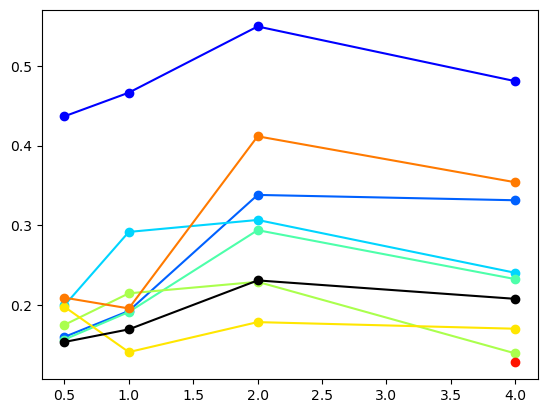

In [6]:
idx_uq = np.unique(isi_all)
col1 = plt.colormaps['jet'](np.linspace(0, 1, 10))

plt.figure()
corr_tn_all = np.zeros((len(trials_analyze), len(idx_uq)))
for n_tn in range(len(trials_analyze)):
    corr_tn = np.full(len(idx_uq), np.nan)
    for n_isi in range(len(idx_uq)):
        idx1 = (idx_uq[n_isi] == np.array(isi_all)).flatten()
        if np.sum(~np.isnan(corr_vals[idx1,n_tn])):
            corr_tn[n_isi] = np.nanmean(corr_vals[idx1,n_tn])
            corr_tn_all[n_tn, n_isi] = np.nanmean(corr_vals[idx1,n_tn])
    if np.sum(~np.isnan(corr_tn)):
        plt.plot(idx_uq, corr_tn, '-o', color=col1[n_tn])
    
plt.plot(idx_uq, np.nanmean(corr_tn_all, axis=0), '-o', color='k')
